In [1]:
from __future__ import division, print_function
import numpy as np
from collections import OrderedDict
import logging

from IPython.display import display
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.wcs
from astropy import coordinates
import astropy.units as apu
from astropy import table

import astropyp
from astropyp.wrappers.astromatic import ldac
from astropyp.phot import stack
import bd_search

alogger = logging.getLogger('astropyp')
alogger.setLevel(logging.INFO)

idx_connect = 'sqlite:////media/data-beta/users/fmooleka/decam/decam.db'
ref_path = '/media/data-beta/users/fmooleka/decam/catalogs/ref/'

# SExtractor 'extract' detection parameters
conv_filter = np.load('/media/data-beta/users/fmooleka/2016decam/5x5gauss.npy')
sex_params = {
    'extract': {
        'thresh': 40,
        #'err':,
        'minarea': 3, # default
        'conv': conv_filter,
        #'deblend_nthresh': 32, #default
        'deblend_cont': 0.001,
        #'clean': True, #default
        #'clean_param': 1 #default
    },
    'kron_k': 2.5,
    'kron_min_radius': 3.5,
    'filter': conv_filter,
    #'thresh': 1.5 # *bkg.globalrms
}

obj='F100'
refname = '2MASS'
#refname = 'UCAC4'
fullref = ldac.get_table_from_ldac(ref_path+'{0}-{1}.fits'.format(obj, refname))

In [2]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

def get_exp_files(expnum, night, filtr, idx_connect):
    sql = 'select * from decam_obs where expnum={0} and filter like "{1}%" and dtcaldat="{2}"'.format(
        expnum, filtr, night)
    exp_info = astropyp.db_utils.index.query(sql, idx_connect)
    img_filename = exp_info[exp_info['PRODTYPE']=='image'][0]['filename']
    img = fits.open(img_filename)
    dqmask_filename = exp_info[exp_info['PRODTYPE']=='dqmask'][0]['filename']
    dqmask = fits.open(dqmask_filename)
    return img, dqmask
  
min_flux = 1000
min_amplitude = 1000
good_amplitude = 50
calibrate_amplitude = 200
frame = 1
explist = [442433, 442434, 442435]
aper_radius = 8

ccds = []

for expnum in explist:
    #img, dqmask = get_exp_files(expnum, "2015-05-26", "i", idx_connect)
    img, dqmask = get_exp_files(expnum, "2015-05-26", "z", idx_connect)
    header = img[frame].header
    wcs = astropy.wcs.WCS(header)
    img_data = img[frame].data
    dqmask_data = dqmask[frame].data
    ccd = astropyp.phot.phot.SingleImage(header, img_data, dqmask_data,
        wcs=wcs, gain=4., exptime=30, aper_radius=aper_radius)
    ccds.append(ccd)

In [3]:
ccd_stack = stack.Stack(ccds, 1)
ccd_stack.detect_sources(min_flux=min_flux, good_amplitude=good_amplitude,
    calibrate_amplitude=calibrate_amplitude, psf_amplitude=1000, sex_params=sex_params, 
    subtract_bkg=True, windowed=False)
ccd_stack.get_transforms()

INFO:astropyp.phot.psf:Total sources: 1099
INFO:astropyp.phot.psf:Sources with low flux: 0
INFO:astropyp.phot.psf:Sources with low amplitude: 757
INFO:astropyp.phot.psf:Sources with bad pixels: 205
INFO:astropyp.phot.psf:Elliptical sources: 81
INFO:astropyp.phot.psf:Source with close neighbors: 230
INFO:astropyp.phot.psf:Sources near an edge: 18
INFO:astropyp.phot.psf:Sources after cuts: 200
INFO:astropyp.phot.psf:Total sources: 1024
INFO:astropyp.phot.psf:Sources with low flux: 0
INFO:astropyp.phot.psf:Sources with low amplitude: 733
INFO:astropyp.phot.psf:Sources with bad pixels: 181
INFO:astropyp.phot.psf:Elliptical sources: 72
INFO:astropyp.phot.psf:Source with close neighbors: 193
INFO:astropyp.phot.psf:Sources near an edge: 15
INFO:astropyp.phot.psf:Sources after cuts: 173
INFO:astropyp.phot.psf:Total sources: 1134
INFO:astropyp.phot.psf:Sources with low flux: 0
INFO:astropyp.phot.psf:Sources with low amplitude: 785
INFO:astropyp.phot.psf:Sources with bad pixels: 246
INFO:astropy

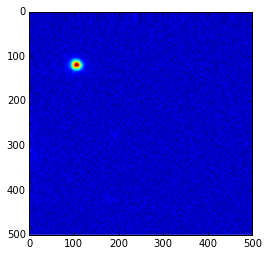

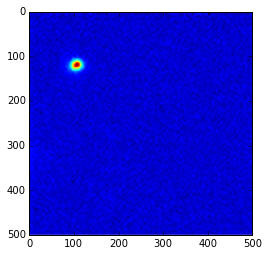

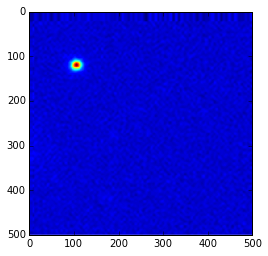

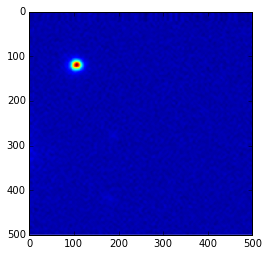

In [5]:
sources = ccd_stack.ccds[1].catalog.sources
idx = (sources['x']>1000) & (sources['x'] < 1500) & (sources['y']>2000) & (sources['y']<3000) & (sources['peak']>500)
x,y = sources[idx][0]['x'],sources[idx][0]['y']
x2 = x+30.1234
y2 = y+30.0063
plt_show = True
data1, X, Y, newpos = astropyp.utils.misc.get_subpixel_patch(ccd_stack.ccds[1].img, (y2, x2), (100,100))
data0, dqmask0, X0, Y0, pos0 = stack.reproject_image(ccd_stack.ccds[0].img, x2, y2, X, Y,
    ccd_stack.tx_solutions[(1,0)], max_offset=0, dqmask=ccd_stack.ccds[0].dqmask)
data2, dqmask2, X2, Y2, pos2 = stack.reproject_image(ccd_stack.ccds[2].img, x2, y2, X, Y,
    ccd_stack.tx_solutions[(1,2)], max_offset=0, dqmask=ccd_stack.ccds[2].dqmask)

stacked = np.ma.mean(np.ma.array([data0, data1, data2]), axis=0)
if plt_show:
    plt.imshow(data0, interpolation='none')
    plt.show()
    plt.imshow(data1, interpolation='none')
    plt.show()
    plt.imshow(data2, interpolation='none')
    plt.show()
    plt.imshow(stacked, interpolation='none')
    plt.show()

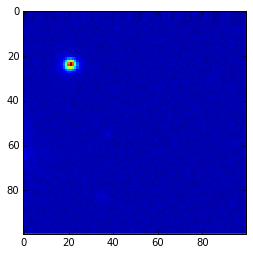

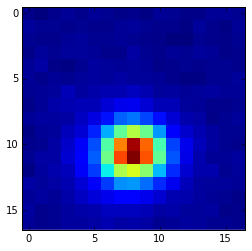

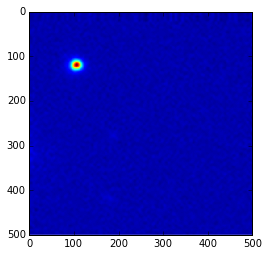

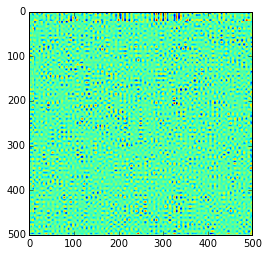

max 17.3976511342
mean 0.00731896257878
stddev 2.64771435726


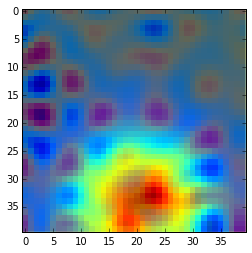

max 9.17290288654
mean 0.0335253164576
stddev 2.94120249497


In [6]:
from scipy.ndimage import zoom
from astropy.nddata.utils import extract_array

mini_stacked = zoom(stacked,1./5)
plt.imshow(mini_stacked, interpolation='none')
plt.show()
data = extract_array(mini_stacked, (17,17), (21,21))
plt.imshow(data, interpolation='none')
plt.show()
mini_stacked.shape
maxi_stacked = zoom(mini_stacked, 5)
plt.imshow(maxi_stacked, interpolation='none')
plt.show()

diff = stacked-maxi_stacked
plt.imshow(diff, interpolation='none')
plt.show()
print('max', np.max(diff))
print('mean', np.mean(diff))
print('stddev', np.std(diff))

s1 = slice(85,125)
diff = diff[s1,s1]
plt.imshow(diff, interpolation='none')
contour = stacked[s1,s1]
X = np.arange(0,contour.shape[1],1)
Y = np.arange(0,contour.shape[0],1)
X,Y = np.meshgrid(X,Y)
plt.imshow(contour, interpolation='none', alpha=.6)
plt.show()

print('max', np.max(diff))
print('mean', np.mean(diff))
print('stddev', np.std(diff))

In [10]:
result = ccd_stack.merge_catalogs()
print(len(ccd_stack.catalog.sources))

INFO:astropyp.phot.stack:x rms: 0.200749353379
INFO:astropyp.phot.stack:y rms: 0.0783453541869
INFO:astropyp.phot.stack:x rms: 0.0217314648602
INFO:astropyp.phot.stack:y rms: 0.0796414436288
INFO:astropyp.phot.stack:x rms: 0.22248081824
INFO:astropyp.phot.stack:y rms: 0.157986797816


1221


In [218]:
def stack_full_images(imgs, ref_index, tx_solutions, dqmasks = None,
            combine_method='mean', dqmask_min=0, bad_pix_val=1,
            buf=10, order=3):
    from scipy import interpolate
    from astropy.nddata import extract_array, overlap_slices
    from astropyp.astrometry import ImageSolution
    
    buf = float(buf)
    
    # Get the minimum size of the final stack by projecting all of
    # the images onto the reference frame
    img_x = np.arange(0, imgs[ref_index].shape[1], 1)
    img_y = np.arange(0, imgs[ref_index].shape[0], 1)
    xmin = img_x[0]-buf
    xmax = img_x[-1]+buf
    ymin = img_y[0]-buf
    ymax = img_y[-1]+buf
    for n in range(len(imgs)):
        if n!=ref_index:
            tx_x,tx_y = tx_solutions[n].transform_coords(
                x=[img_x[0], img_x[-1]],
                y=[img_y[0], img_y[-1]])
            if tx_x[0]<xmin:
                xmin = tx_x[0]
            if tx_x[1]>xmax:
                xmax = tx_x[1]
            if tx_y[0]<ymin:
                ymin = tx_y[0]
            if tx_y[1]>ymax:
                ymax = tx_y[1]
    x_tx = OrderedDict([('Intercept', xmin), ('A_1_0', 1.0), ('A_0_1', 0.0)])
    y_tx = OrderedDict([('Intercept', ymin), ('B_1_0', 1.0), ('B_0_1', 0.0)])
    
    # Modify the tx solutions to fit the coadd
    for n in range(len(imgs)):
        if n!= ref_index:
            new_x_tx = tx_solutions[n].x_tx.copy()
            new_y_tx = tx_solutions[n].y_tx.copy()
            new_x_tx['Intercept'] += xmin
            new_y_tx['Intercept'] += ymin
            tx_solutions[n] = ImageSolution(x_tx=new_x_tx, y_tx=new_y_tx,
                order=tx_solutions[n].order)
        else:
            tx_solutions[n] = ImageSolution(x_tx=x_tx, y_tx=y_tx, order=1)
    
    coadd_x = np.arange(0, xmax-xmin, 1)
    coadd_y = np.arange(0, ymax-ymin, 1)
    Xc, Yc = np.meshgrid(coadd_x, coadd_y)
    patches = []
    # Reproject each image to the coadded image
    for n in range(len(imgs)):
            tx_x,tx_y = tx_solutions[n].transform_coords(
                x=Xc.flatten(),y=Yc.flatten())
            tx_x = np.array(tx_x).reshape(Xc.shape)
            tx_y = np.array(tx_y).reshape(Yc.shape)
            img_x = np.arange(0, imgs[n].shape[1], 1)
            img_y = np.arange(0, imgs[n].shape[0], 1)
            # Create an interpolating function and reproject the image
            data_func = interpolate.RectBivariateSpline(img_y, img_x, 
                imgs[n],kx=order,ky=order)
            patch = data_func(tx_y.flatten(), tx_x.flatten(), grid=False)
            patch = patch.reshape(Xc.shape)
            #Create the dqmask
            if dqmasks is not None:
                points = (img_y, img_x)
                values = dqmasks[n]
                dq_func = interpolate.RegularGridInterpolator(
                    points, values, method='nearest', 
                    fill_value=bad_pix_val, bounds_error=False)
                dqmask = dq_func(zip(tx_y.flatten(),tx_x.flatten()))
                dqmask = dqmask.reshape(Xc.shape)
                dqmask = dqmask.astype(bool)
            else:
                dqmask = None
            
            # Apply the dqmask to the image
            patch[dqmask>dqmask_min] = np.nan
            patch[dqmask>dqmask_min] 
            patch = np.ma.array(patch)
            patch.mask = np.isnan(patch)
            
            patches.append(patch)
    stack = np.ma.mean(patches, axis=0)
    dqmask = patches[0].mask
    for n in range(1,len(patches)):
        dqmask = np.bitwise_and(dqmask, patches[n].mask)
    return stack, dqmask, patches

#imgs = [ccd.img for ccd in ccd_stack.ccds]
#dqmasks = [ccd.dqmask for ccd in ccd_stack.ccds]
imgs = [ccd.img[:200,:100] for ccd in ccd_stack.ccds]
dqmasks = [ccd.dqmask[:200,:100] for ccd in ccd_stack.ccds]
tx_solutions = [ccd_stack.tx_solutions[(1,0)], None, ccd_stack.tx_solutions[(1,2)]]
stack, dqmask, patches = stack_full_images(imgs, 1, tx_solutions, dqmasks)

In [216]:
imgs = [ccd.img for ccd in ccd_stack.ccds]
dqmasks = [ccd.dqmask for ccd in ccd_stack.ccds]
tx_solutions = [ccd_stack.tx_solutions[(1,0)], None, ccd_stack.tx_solutions[(1,2)]]

%time stack, dqmask, patches=stack_full_images(imgs, 1, tx_solutions, dqmasks, order=5)

CPU times: user 4min 2s, sys: 19.6 s, total: 4min 21s
Wall time: 4min 22s


In [219]:
imgs = [ccd.img for ccd in ccd_stack.ccds]
dqmasks = [ccd.dqmask for ccd in ccd_stack.ccds]
tx_solutions = [ccd_stack.tx_solutions[(1,0)], None, ccd_stack.tx_solutions[(1,2)]]

%time stack, dqmask, patches=stack_full_images(imgs, 1, tx_solutions, dqmasks, order=3)

CPU times: user 3min 56s, sys: 20.1 s, total: 4min 16s
Wall time: 4min 17s


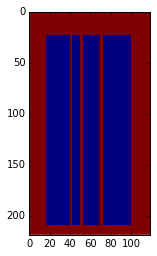

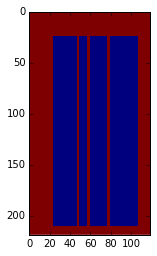

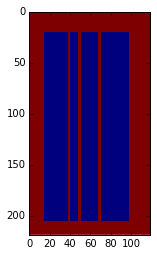

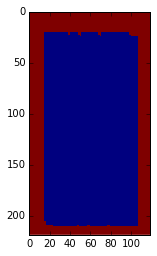

In [213]:
for dqmask in dqmasks:
    plt.imshow(dqmask, interpolation='none')
    plt.show()
dqmask = dqmasks[0]
for n in range(1, len(dqmasks)):
    dqmask = np.bitwise_and(dqmask, dqmasks[n])
plt.imshow(dqmask, interpolation='none')
plt.show()

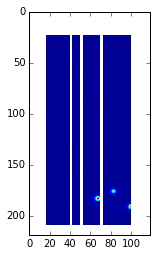

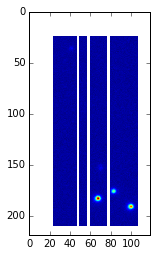

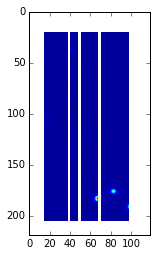

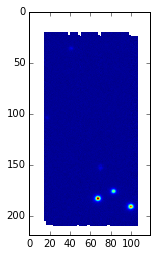

In [210]:
for patch in patches:
    plt.imshow(patch, interpolation='none')
    plt.show()
stack = np.ma.mean(patches, axis=0)
plt.imshow(stack, interpolation='none')
plt.show()

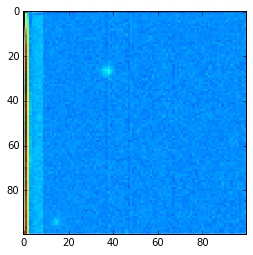

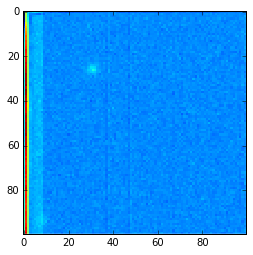

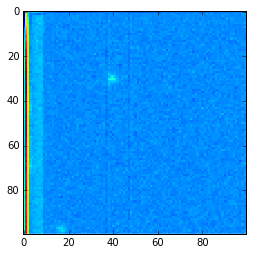

In [174]:
for ccd in ccd_stack.ccds:
    plt.imshow(ccd.img[:100,:100], interpolation='none')
    plt.show()

In [157]:
def stack(imgs, dqmasks, x_range, y_range, x_buffer, y_buffer, 
        ref_index, tx_solutions, combine_method='mean', dqmask_min=0, 
        bad_pix_val=1):
    from scipy import interpolate
    from astropy.nddata import extract_array, overlap_slices
    patch_x = np.arange(x_range[0],x_range[1], 1)
    patch_y = np.arange(y_range[0],y_range[1], 1)
    wide_x = np.arange(x_range[0]-x_buffer, x_range[1]+x_buffer, 1)
    wide_y = np.arange(y_range[0]-y_buffer, y_range[1]+y_buffer, 1)
    
    patch_data = []
    patch_dqmask = []
    X,Y = np.meshgrid(wide_x, wide_y)
    coords = zip(X.flatten(), Y.flatten())
    
    src_pos = (0.5*(y_range[1]+y_range[0]),
               0.5*(x_range[1]+x_range[0]))
    src_shape = (y_range[1]-y_range[0],x_range[1]-x_range[0])
    wide_shape = (y_range[1]-y_range[0]+2*y_buffer,
                  x_range[1]-x_range[0]+2*x_buffer)
    
    for n in range(len(imgs)):
        if n!= ref_index:
          if False:
            tx_x,tx_y = tx_solutions[n].transform_coords(
                x=patch_x,y=patch_y)
            large_slices, small_slices = overlap_slices(imgs[n].shape,
                                            wide_shape, src_pos, mode='partial')
            data_slice = imgs[n][large_slices]
            wide_x = np.arange(large_slices[1].start, large_slices[1].stop, 1)
            wide_y = np.arange(large_slices[0].start, large_slices[0].stop, 1)
            data_slice = extract_array(imgs[n], wide_shape, src_pos)
            X,Y = np.meshgrid(wide_x, wide_y)
            coords = zip(X.flatten(), Y.flatten())
            
            tx_x, tx_y = np.meshgrid(tx_x, tx_y)
            new_coords = zip(tx_x.flatten(), tx_y.flatten())
            patch = interpolate.griddata(coords, data_slice.flatten(),
                                        new_coords, method='cubic')
            patch = patch.reshape(src_shape)
          else:
            tx_x,tx_y = tx_solutions[n].transform_coords(
                x=patch_x,y=patch_y)
            large_slices, small_slices = overlap_slices(imgs[n].shape,
                                            wide_shape, src_pos, mode='partial')
            data_slice = imgs[n][large_slices]
            wide_x = np.arange(large_slices[1].start, large_slices[1].stop, 1)
            wide_y = np.arange(large_slices[0].start, large_slices[0].stop, 1)
            data_func = interpolate.RectBivariateSpline(wide_y, wide_x, 
                                                        data_slice,kx=5,ky=5,s=0)
            X = np.array(tx_x)
            Y = np.array(tx_y)
            patch = data_func(Y, X)
            X,Y = np.meshgrid(wide_x, wide_y)
            coords = zip(X.flatten(), Y.flatten())
            
        else:
            patch = extract_array(imgs[n], src_shape, src_pos)
        patch_data.append(patch)
        
    return patch_data, patch_dqmask

imgs = [ccd.img for ccd in ccd_stack.ccds]
dqmasks = [ccd.dqmask for ccd in ccd_stack.ccds]
tx_solutions = [ccd_stack.tx_solutions[(1,0)], None, ccd_stack.tx_solutions[(1,2)]]
patches, dqmasks = stack(imgs, dqmasks, (0,100), (0,100), 50, 50, 1, tx_solutions)

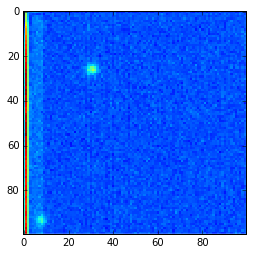

In [158]:
stk = np.mean(patches, axis=0)
plt.imshow(stk, interpolation='none')
plt.show()

In [31]:
X = np.arange(0,550,1)
Y = np.arange(0,550,1)
X0,Y0 = ccd_stack.tx_solutions[(1,0)].transform_coords(x=X[:500],y=Y[:500])
from scipy import interpolate
X,Y = np.meshgrid(X,Y)
X0,Y0 = np.meshgrid(X0,Y0)
coords = zip(X.flatten(), Y.flatten())
new_coords = zip(X0.flatten(),Y0.flatten())
data = ccd_stack.ccds[0].img[:550,:550]
new_data = interpolate.griddata(coords, data.flatten(), new_coords, method='cubic')

In [33]:
new_data = new_data.reshape(500,500)

In [35]:
dqmask = ccd_stack.ccds[0].dqmask[:550,:550]
new_dqmask = interpolate.griddata(coords, dqmask.flatten(), new_coords, method='nearest')
new_dqmask = new_dqmask.reshape(500,500)

In [223]:
max_offset=3
ccd = astropyp.phot.phot.SingleImage(img=stack, dqmask=dqmask, gain=4., exptime=30, aper_radius=8)
#ccd = astropyp.phot.phot.SingleImage(img=stack, gain=4., exptime=30, aper_radius=8)
ccd.detect_sources(sex_params, subtract_bkg=True)
ccd.select_psf_sources(min_flux, min_amplitude, edge_dist=aper_radius+max_offset, badpix_flags=[])
psf_array = ccd.create_psf()
ccd.show_psf()
good_idx = ccd.catalog.sources['peak']>calibrate_amplitude
good_idx = good_idx & (ccd.catalog.sources['pipeline_flags']==0)
result = ccd.perform_psf_photometry(indices=good_idx)

ValueError: total size of new array must be unchanged

In [156]:
good_idx = ccd.catalog.sources['peak']>calibrate_amplitude
good_idx = good_idx & (ccd.catalog.sources['pipeline_flags']==0)
good_idx = good_idx & np.isfinite(ccd.catalog.sources['psf_mag'])
good_sources = ccd.catalog.sources[good_idx]

print('rms', np.sqrt(np.sum(good_sources['psf_mag_err']**2/len(good_sources))))
print('mean', np.mean(good_sources['psf_mag_err']))
print('median', np.median(good_sources['psf_mag_err']))
print('stddev', np.std(good_sources['psf_mag_err']))

bad_count = np.sum(good_sources['psf_mag_err']>.05)
print('bad psf error: {0}, or {1}%'.format(bad_count, bad_count/len(good_sources)*100))
print('Better than 5%: {0} of {1}'.format(np.sum(good_sources['psf_mag_err']<=.05), len(good_sources)))
print('Better than 2%: {0} of {1}'.format(np.sum(good_sources['psf_mag_err']<=.02), len(good_sources)))
good_sources['aper_flux','psf_flux','peak','psf_mag_err'][good_sources['psf_mag_err']>.05]

rms 0.230426043353
mean 0.0815163811891
median 0.0126329265291
stddev 0.215525499774
bad psf error: 10, or 16.9491525424%
Better than 5%: 49 of 59
Better than 2%: 36 of 59


aper_flux,psf_flux,peak,psf_mag_err
float64,float64,float64,float64
1550.52688631,2996.43234736,296.332305908,0.414247884594
17557.2001031,11338.8027226,400.847351074,0.663460846327
10493.1315121,10153.0775772,459.268859863,0.130812839519
3985.23971693,4713.26981115,239.199768066,0.0728786407252
224269.888738,100570.366292,2926.08105469,1.0497109359
12214.820851,12090.3559384,558.847839355,0.0663393391841
448128.02679,441220.984175,20290.3203125,0.110502696783
2077.59734785,3266.49945401,285.013244629,0.314489363833
237069.955358,99473.9103145,2866.93334961,1.09423874999


In [40]:
ccd.catalog.sources

thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,y2,xy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,aper_radius,aper_flux,aper_flux_err,aper_flag,aper_mag,aper_mag_err,flags,src_idx,pipeline_flags,psf_flux,psf_flux_err,psf_mag,psf_mag_err,psf_x,psf_y
float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,int16,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64
40.0,14,14,29,32,24,27,30.5113542688,25.72659371,1.06170139896,1.00835553688,0.00511553775316,1.03062486649,1.00392699242,0.0947433561087,0.941907465458,0.991737961769,-0.00955687370151,661.811462402,1316.6640625,53.9803924561,151.617797852,31,26,31,26,0,8,2402.6200549,24.5082641924,0,-4.75890960783,0.115935115373,1,0,128,nan,nan,nan,nan,nan,nan
40.0,19,17,452,456,26,30,453.782363511,28.3828574674,1.51212813878,1.30688981324,-0.0168864927198,1.23024725914,1.14258909225,-0.0815466716886,0.661415040493,0.765285849571,0.0170924589038,931.768737793,1672.90698242,58.9475784302,167.398452759,454,28,454,29,0,8,2730.63582279,26.1277430272,0,-4.89785632162,0.102072010793,0,1,0,nan,nan,nan,nan,nan,nan
40.0,22,19,119,124,27,31,121.501134817,29.2914329509,1.85980482091,1.38878535957,0.00965288687743,1.36381912231,1.17838346958,0.0204821415246,0.537710249424,0.720079660416,-0.00747481407598,1131.92724609,1951.10424805,63.2994308472,160.293838501,122,29,121,29,0,8,3005.02568623,27.4090572906,0,-5.0018173347,0.0928000402537,0,2,0,nan,nan,nan,nan,nan,nan
40.0,26,14,230,236,37,41,232.81376673,39.3907032486,2.96212288215,1.55455254271,-0.512024439742,1.76880538464,1.17813539505,-0.314482092857,0.357976824045,0.68210709095,0.235814332962,1492.0177002,2559.95556641,71.7345581055,416.806304932,233,39,234,39,1,8,4575.69984992,33.821959767,0,-5.45834068446,0.0611262037594,7,3,131,nan,nan,nan,nan,nan,nan
40.0,54,26,221,231,38,45,224.917377466,41.9050913401,8.01831317377,2.62799602686,-2.15728920204,2.96232485771,1.36782360077,-0.337501943111,0.16006603837,0.488379597664,0.262792438269,3287.49682617,4352.71337891,86.8145065308,365.692016602,224,42,225,42,1,8,5275.00666491,36.3146205574,0,-5.61275439494,0.053092504109,7,4,131,nan,nan,nan,nan,nan,nan
40.0,141,99,365,377,34,46,370.817936744,39.8429046231,6.41122201767,6.19016261159,0.103704322146,2.5401289463,2.4797437191,0.376774728298,0.156018778682,0.16159042716,-0.00522759184241,33998.5820312,35459.3789062,762.218505859,2088.67700195,371,40,371,40,0,8,35938.4932993,94.7872529659,0,-7.69609652722,0.00822950244365,0,5,0,39389.9099534,109.103433343,-7.7956593332,0.00276983200704,370.953253468,39.8117687238
40.0,121,83,340,352,52,63,345.723192013,57.6488690477,6.07299486345,5.71488440686,0.106104438236,2.4702372551,2.38449311256,0.267472654581,0.16471683979,0.175038442016,-0.00611637486145,22493.5117188,23789.7460938,514.271362305,1386.57861328,346,58,346,58,0,8,24719.7310688,78.612548408,0,-7.28980621735,0.0117360902503,0,6,0,26944.2589262,83.3598213461,-7.3833624714,0.0030937878668,345.884516771,57.5854339411
40.0,4,4,310,311,139,140,310.502368789,139.503034145,0.249994388839,0.249990793967,-6.99152406316e-05,0.500062525272,0.499922633171,-0.772546589375,4.00009012222,4.00014781952,0.00223742052913,169.517120361,442.285888672,42.8265914917,129.372833252,311,140,311,140,0,8,2363.30943187,24.3069405308,0,-4.74099833376,0.117854748371,0,7,0,nan,nan,nan,nan,nan,nan
40.0,8,8,410,413,139,141,411.500257799,140.006988233,0.716785573036,0.499364800729,0.00136943508478,0.846637010574,0.706651389599,0.00629821466282,1.39512467384,2.00255441666,-0.00765185151249,344.508422852,818.664123535,46.0384674072,139.202041626,412,140,411,140,0,8,2266.17514122,23.8021802637,0,-4.69543054133,0.122883639405,0,8,0,nan,nan,nan,nan,nan,nan
